In [2]:
import pandas as pd


# Load the data
voting_df = pd.read_csv('data/voting-by-county.csv')

# Filter for the year 2020
voting_df = voting_df.query('year == 2020')

# Filter for the two main parties
voting_df = voting_df[voting_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])]

# Create the new column
voting_df['percent_votes'] = voting_df['candidatevotes'] / voting_df['totalvotes']

# Drop unnecessary columns
voting_df = voting_df.drop(columns=['candidatevotes', 'totalvotes', 'office', 'candidate', 'version', 'mode', 'state', 'state_po', 'year', 'county_name'])

# Group by county_fips and party, and aggregate percent_votes
voting_df = voting_df.groupby(['county_fips', 'party']).agg({'percent_votes': 'mean'}).reset_index()

# Pivot the DataFrame
pivot_df = voting_df.pivot(index='county_fips', columns='party', values='percent_votes')

# Rename the columns
pivot_df = pivot_df.rename(columns={'DEMOCRAT': 'percent_democrat', 'REPUBLICAN': 'percent_republican'})

# Reset the index to make county_fips a column again
pivot_df = pivot_df.reset_index()

# Convert county_fips to integer and rename to FIPS
pivot_df['county_fips'] = pivot_df['county_fips'].astype(int)
pivot_df = pivot_df.rename(columns={'county_fips': 'FIPS'})

# Display the first 10 rows to verify
voting_df = pivot_df[['FIPS', 'percent_democrat', 'percent_republican']]

voting_df.head(10)

party,FIPS,percent_democrat,percent_republican
0,1001,0.270184,0.714368
1,1003,0.224090,0.761714
2,1005,0.457882,0.534512
3,1007,0.206983,0.784263
4,1009,0.095694,0.895716
5,1011,0.747019,0.248428
6,1013,0.417896,0.575253
7,1015,0.298452,0.688484
8,1017,0.416449,0.572690
9,1019,0.132022,0.860337


In [3]:
vaccine_df = pd.read_csv('data/CDC_covid_data.csv')

vaccine_df = vaccine_df[['FIPS', 'Administered_Dose1_Recip_18PlusPop_Pct']]

vaccine_df = vaccine_df.dropna()


# Sort vaccine_df based on FIPS
vaccine_df = vaccine_df[vaccine_df['FIPS'].apply(lambda x: str(x).isdigit())]
vaccine_df['FIPS'] = vaccine_df['FIPS'].astype(int)
#vaccine_df = vaccine_df.sort_values(by='FIPS')

vaccine_df.head(10)

/var/folders/30/tv8y9sjj267fr2h48qhlgsh00000gn/T/ipykernel_5237/1351102543.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  vaccine_df = pd.read_csv('data/CDC_covid_data.csv')


,FIPS,Administered_Dose1_Recip_18PlusPop_Pct
0,55129,81.3
1,19173,63.3
2,36059,95.0
3,48281,64.6
5,13101,49.2
6,12013,50.9
7,17027,76.8
9,48421,58.4
11,47081,57.9
12,50027,73.8


In [4]:
# literacy dataset

''' 
data from : https://nces.ed.gov/surveys/piaac/skillsmap/
'''

literacy_df = pd.read_csv('data/literacy_rates.csv')
literacy_df = literacy_df[literacy_df['grpName'] == 'all']
literacy_df = literacy_df[['FIPS_code', 'Lit_A']]
literacy_df = literacy_df.rename(columns={'FIPS_code': 'FIPS', 'Lit_A': 'avg_literacy_score'})


In [20]:
# life expectancy dataset

''' 
Downloaded from : https://ghdx.healthdata.org/record/ihme-data/united-states-life-expectancy-by-county-race-ethnicity-2000-2019
Based on this paper: https://www.sciencedirect.com/science/article/pii/S0140673622008765?via%3Dihub#cesec90 
'''

# read in 
life_expectancy_df = pd.read_csv('data/life_expectancy_2019_both.csv')

# all races
life_expectancy_df = life_expectancy_df[life_expectancy_df['race_id'] == 1]

# slim down 
life_expectancy_df = life_expectancy_df[['fips', 'val']]

# fips int conversion 
life_expectancy_df = life_expectancy_df.dropna(subset=['fips', 'val'])
life_expectancy_df = life_expectancy_df[pd.to_numeric(life_expectancy_df['fips'], errors='coerce').notnull()]
life_expectancy_df['fips'] = life_expectancy_df['fips'].astype(int)

# rename columns
life_expectancy_df = life_expectancy_df.rename(columns={'fips': 'FIPS', 'val': 'life_expectancy'})

# In case of multiple FIPS present, pick the one with the higher life_expectancy
life_expectancy_df = life_expectancy_df.loc[life_expectancy_df.groupby('FIPS')['life_expectancy'].idxmax()]

# Display the resulting DataFrame
life_expectancy_df['life_expectancy'].value_counts()

life_expectancy
80.268922    7
80.545202    6
82.480432    5
85.682486    3
80.308733    3
            ..
75.830367    1
72.207049    1
78.642509    1
73.703272    1
79.568976    1
Name: count, Length: 3129, dtype: int64

In [21]:
merged_df = pd.merge(vaccine_df, voting_df, on='FIPS')
merged_df = pd.merge(merged_df, literacy_df, on='FIPS')
merged_df = pd.merge(merged_df, life_expectancy_df, on='FIPS', how='inner')


# Drop rows where Administered_Dose1_Recip_18PlusPop_Pct is 0
merged_df = merged_df[merged_df['Administered_Dose1_Recip_18PlusPop_Pct'] != 0]

# Drop rows with any NaN values
merged_df = merged_df.dropna()

# Sort the filtered DataFrame by Administered_Dose1_Recip_18PlusPop_Pct in descending order
merged_df = merged_df.sort_values(by='Administered_Dose1_Recip_18PlusPop_Pct', ascending=False)

# Drop duplicate rows based on FIPS, keeping the first occurrence
merged_df = merged_df.drop_duplicates(subset='FIPS', keep='first')

merged_df['political_affiliation'] = merged_df.apply(
    lambda row: 0 if row['percent_democrat'] > row['percent_republican'] else 1, axis=1
)

# Display the first 10 rows to verify
print(merged_df.shape)
merged_df.head(10)

(3068, 7)


,FIPS,Administered_Dose1_Recip_18PlusPop_Pct,percent_democrat,percent_republican,avg_literacy_score,life_expectancy,political_affiliation
828268,8097,100.0,0.751777,0.232500,283.2,91.342130,0
1378386,30035,100.0,0.642692,0.335410,250.2,72.113473,0
1172744,42029,100.0,0.579875,0.408789,283.0,81.528558,0
987592,22125,100.0,0.366624,0.616305,244.3,77.259754,1
913451,30087,100.0,0.317784,0.658892,260.7,74.473644,1
1008033,42091,100.0,0.626299,0.363535,285.1,80.957606,0
826467,42077,100.0,0.532112,0.456162,262.9,79.665674,0
996317,56039,100.0,0.665990,0.293569,282.2,85.905597,0
1038016,49043,100.0,0.146094,0.098252,282.6,83.562692,0
1144376,37117,100.0,0.117843,0.130223,250.0,75.139568,1


In [22]:
# Assuming merged_df is already created and cleaned as per the previous steps

# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                                            FIPS  \
FIPS                                    1.000000   
Administered_Dose1_Recip_18PlusPop_Pct  0.055985   
percent_democrat                       -0.031955   
percent_republican                      0.087967   
avg_literacy_score                      0.039321   
life_expectancy                         0.043961   
political_affiliation                   0.026980   

                                        Administered_Dose1_Recip_18PlusPop_Pct  \
FIPS                                                                  0.055985   
Administered_Dose1_Recip_18PlusPop_Pct                                1.000000   
percent_democrat                                                      0.464298   
percent_republican                                                   -0.358916   
avg_literacy_score                                                    0.162815   
life_expectancy                                                       0.220990   
political

In [23]:
import pandas as pd
import statsmodels.api as sm

# Assuming merged_df is already created and contains 'life_expectancy' and 'literacy_score'

# Prepare the data for regression
X = merged_df['Administered_Dose1_Recip_18PlusPop_Pct']
y = merged_df['life_expectancy']

# Add a constant to the independent variable (required for statsmodels)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     157.4
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           3.00e-35
Time:                        15:02:42   Log-Likelihood:                -7206.5
No. Observations:                3068   AIC:                         1.442e+04
Df Residuals:                    3066   BIC:                         1.443e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming merged_df is already created and contains the necessary columns

# Prepare the data
X = merged_df.drop(columns=['political_affiliation', 'percent_democrat', 'percent_republican', 'FIPS'])
y = merged_df['political_affiliation']

# Split the data into training and testing sets (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict the political affiliation on the test set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

# Extract the coefficients and pair them with their corresponding feature names
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_[0]
})

# Display the feature importances
# negative means more likely to be democrat! 
print(feature_importance.sort_values(by='Importance', ascending=False))

Model Accuracy: 0.84
                                  Feature  Importance
1                      avg_literacy_score    0.030925
0  Administered_Dose1_Recip_18PlusPop_Pct   -0.089835
2                         life_expectancy   -0.167126


In [18]:
merged_df['life_expectancy'].value_counts()

life_expectancy
61.401495    2
79.536317    2
80.268922    2
7.406225     2
69.446763    1
            ..
10.071525    1
31.199789    1
57.401034    1
38.719359    1
73.412471    1
Name: count, Length: 3064, dtype: int64

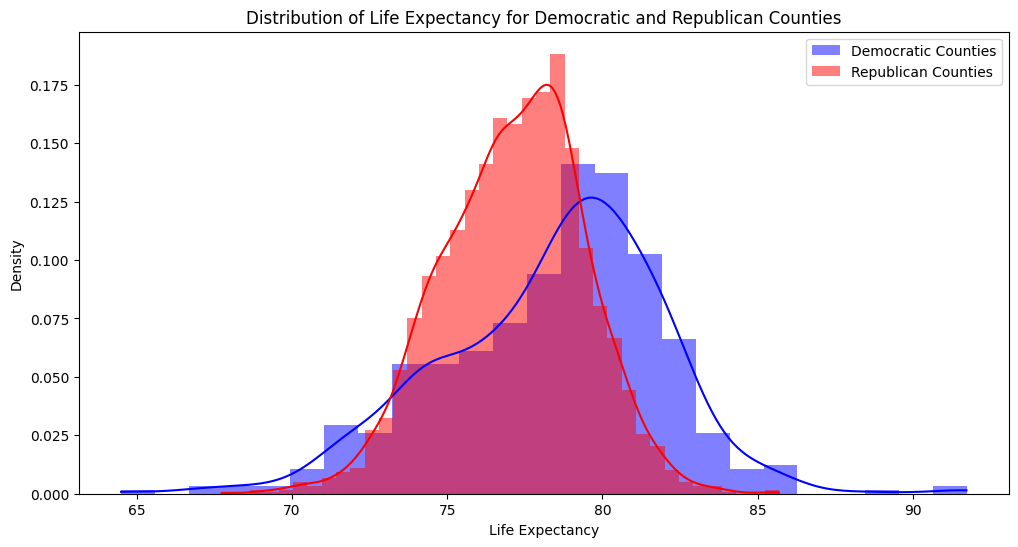

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate the data into Democratic and Republican counties
democratic_counties = merged_df[merged_df['political_affiliation'] == 0]
republican_counties = merged_df[merged_df['political_affiliation'] == 1]

# Plot the distribution of life expectancy for both groups
plt.figure(figsize=(12, 6))
sns.histplot(democratic_counties['life_expectancy'], color='blue', label='Democratic Counties', kde=True, stat="density", linewidth=0)
sns.histplot(republican_counties['life_expectancy'], color='red', label='Republican Counties', kde=True, stat="density", linewidth=0)

# Add labels and title
plt.xlabel('Life Expectancy')
plt.ylabel('Density')
plt.title('Distribution of Life Expectancy for Democratic and Republican Counties')
plt.legend()

# Show the plot
plt.show()